Preprocessing Anime dataset from Kaggle

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import re
import string
import itertools

1. Data preprocessing

1.1 Data Cleaning

Anime data

In [2]:
# remove unwanted features (columns) from the dataset
anime_df = pd.read_csv("animes.csv")
anime_df.rename(columns={'title': 'name'}, inplace=True)
anime_df.drop(['aired', 'ranked', 'img_url', 'link'], axis=1, inplace=True)

#removing unwanted characters from the anime name strings
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)

    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)
anime_df.head(5)

,uid,name,synopsis,genre,episodes,members,popularity,score
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [3]:
anime_df.rename(columns={'uid': 'anime_uid', 'score': 'rating'}, inplace=True)
anime_df.episodes.replace({'Unknown':np.nan},inplace=True)

anime_df.drop_duplicates(subset=['name'], inplace=True)
anime_df.dropna(inplace=True)
anime_df.reset_index(drop=True, inplace=True)

anime_df.head(5)

,anime_uid,name,synopsis,genre,episodes,members,popularity,rating
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [4]:
# replace the characters "[]'" with an empty space as the genre column is already of type string
anime_df['genre'] = anime_df['genre'].str.replace("'", "", regex=False)
anime_df['genre'] = anime_df['genre'].str.replace("[", "", regex=False)
anime_df['genre'] = anime_df['genre'].str.replace("]", "", regex=False)

anime_df.head(5)

,anime_uid,name,synopsis,genre,episodes,members,popularity,rating
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire",1.0,214621,502,8.83


Ratings data

In [5]:
user_ratings_df = pd.read_csv("reviews.csv")
user_ratings_df.drop(['link', 'text'], axis=1, inplace=True)
user_ratings_df.rename(columns={'profile': 'user_id'}, inplace=True)

user_ratings_df.user_id = pd.factorize(user_ratings_df.user_id)[0]

user_ratings_df.head()

,uid,user_id,anime_uid,score,scores
0,255938,0,34096,8,"{'Overall': '8', 'Story': '8', 'Animation': '8..."
1,259117,1,34599,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
2,253664,2,28891,7,"{'Overall': '7', 'Story': '7', 'Animation': '9..."
3,8254,3,2904,9,"{'Overall': '9', 'Story': '9', 'Animation': '9..."
4,291149,4,4181,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."


In [6]:
user_ratings_df['scores'] = user_ratings_df['scores'].str.replace("'", "", regex=False)
user_ratings_df['scores'] = user_ratings_df['scores'].str.replace("{", "", regex=False)
user_ratings_df['scores'] = user_ratings_df['scores'].str.replace("}", "", regex=False)

user_ratings_df.head()

,uid,user_id,anime_uid,score,scores
0,255938,0,34096,8,"Overall: 8, Story: 8, Animation: 8, Sound: 10,..."
1,259117,1,34599,10,"Overall: 10, Story: 10, Animation: 10, Sound: ..."
2,253664,2,28891,7,"Overall: 7, Story: 7, Animation: 9, Sound: 8, ..."
3,8254,3,2904,9,"Overall: 9, Story: 9, Animation: 9, Sound: 10,..."
4,291149,4,4181,10,"Overall: 10, Story: 10, Animation: 8, Sound: 9..."


In [7]:
user_ratings_df['scores'] = [re.sub("[^0-9,]", "", anime) for anime in user_ratings_df['scores']]

user_ratings_df.head()

,uid,user_id,anime_uid,score,scores
0,255938,0,34096,8,"8,8,8,10,9,8"
1,259117,1,34599,10,"10,10,10,10,10,10"
2,253664,2,28891,7,"7,7,9,8,8,8"
3,8254,3,2904,9,"9,9,9,10,10,9"
4,291149,4,4181,10,"10,10,8,9,10,10"


In [8]:
category_ratings_df = user_ratings_df['scores'].str.split(",", expand=True)
category_ratings_df.columns = ['Overall', 'Story', 'Animation','Sound', 'Character', 'Enjoyment']

category_ratings_df.head(10)

,Overall,Story,Animation,Sound,Character,Enjoyment
0,8,8,8,10,9,8
1,10,10,10,10,10,10
2,7,7,9,8,8,8
3,9,9,9,10,10,9
4,10,10,8,9,10,10
5,10,9,10,10,10,10
6,6,6,9,8,6,6
7,8,7,9,0,0,9
8,10,10,9,10,10,10
9,4,8,9,8,5,4


In [9]:
user_ratings_df = pd.concat([user_ratings_df, category_ratings_df], axis=1)
user_ratings_df.drop(columns=['score', 'scores', 'uid'], inplace=True)

user_ratings_df.head()

,user_id,anime_uid,Overall,Story,Animation,Sound,Character,Enjoyment
0,0,34096,8,8,8,10,9,8
1,1,34599,10,10,10,10,10,10
2,2,28891,7,7,9,8,8,8
3,3,2904,9,9,9,10,10,9
4,4,4181,10,10,8,9,10,10


USE MERGED DATASET FOR BOTH CB AND CF RECOMMENDATION METHODS TO PREVENT THE INDEX ERROR OCCURING IN THE HYBRID METHOD -> SOME ANIMES ARE REMOVED AFTER MERGING SO LEADS TO INDEX ERROR

In [10]:
anime_with_ratings_df = pd.merge(anime_df, user_ratings_df, on='anime_uid')

anime_with_ratings_df.drop_duplicates(subset=['user_id', 'name'], inplace=True)
anime_with_ratings_df.reset_index(drop=True, inplace=True)

anime_with_ratings_df.head()

,anime_uid,name,synopsis,genre,episodes,members,popularity,rating,user_id,Overall,Story,Animation,Sound,Character,Enjoyment
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,2,7,7,9,8,8,8
1,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15102,10,10,9,9,10,10
2,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15103,10,10,9,9,10,10
3,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,13930,7,7,7,9,0,6
4,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,599,8,7,7,9,8,9


Content based filtering recommendation

USE IN FINAL REPORT:

Normalizing ratings is important in content-based recommenders for anime (and any other system) for several reasons:

Fairness: Different users may have different rating scales. For example, one user may only give a rating of 4 or 5 if they really loved the anime, while another user may give a rating of 3 if they thought it was just okay. Normalizing the ratings ensures that each user's ratings are treated equally and fairly, regardless of their personal rating scale.

Consistency: Normalizing the ratings ensures that they all fall within the same range, making it easier to compare the ratings of different anime. This helps to ensure that the recommendations are consistent and reliable.

Accuracy: Normalizing the ratings can help to reduce the impact of outliers, which can skew the results of the recommender system. By scaling the ratings to a common range, outliers can be identified and handled appropriately, leading to more accurate recommendations.

In summary, normalizing ratings in a content-based recommender for anime helps to ensure fairness, consistency, and accuracy in the recommendations provided to users.

In [64]:
normalised_anime_df = anime_df.copy()

weights = {
    'genre': 0.35,
    'members_norm': 0.1,
    'rating_norm': 0.35,
    'popularity_norm': 0.1,
    'episodes_norm': 0.1
}

normalised_anime_df['members_norm'] = normalised_anime_df['members'] / normalised_anime_df['members'].max() * weights['members_norm']
normalised_anime_df['avg_rating_norm'] = normalised_anime_df['rating'] / normalised_anime_df['rating'].max() * weights['rating_norm']
normalised_anime_df['popularity_norm'] = normalised_anime_df['popularity'] / normalised_anime_df['popularity'].max() * weights['popularity_norm']
normalised_anime_df['episodes_norm'] = normalised_anime_df['episodes'] / normalised_anime_df['episodes'].max() * weights['episodes_norm']

normalised_anime_df.head()

,anime_uid,name,synopsis,genre,episodes,members,popularity,rating,members_norm,avg_rating_norm,popularity_norm,episodes_norm
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,0.026183,0.334453,0.000864,0.000818
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen",22.0,995473,28,8.83,0.053204,0.334832,0.000172,0.000720
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",13.0,581663,98,8.83,0.031088,0.334832,0.000600,0.000425
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,0.086320,0.350000,0.000025,0.002094
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire",1.0,214621,502,8.83,0.011471,0.334832,0.003076,0.000033


In [12]:
normalised_anime_df.drop(['members', 'rating', 'popularity', 'episodes'], axis=1, inplace=True)

normalised_anime_df.head()

,anime_uid,name,synopsis,genre,members_norm,avg_rating_norm,popularity_norm,episodes_norm
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",0.013091,0.382232,0.000864,0.000409
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen",0.026602,0.382665,0.000172,0.000360
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",0.015544,0.382665,0.000600,0.000213
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",0.043160,0.400000,0.000025,0.001047
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire",0.005735,0.382665,0.003076,0.000016


In [13]:
genres_df = anime_df['genre'].str.get_dummies(sep=', ').astype(int)
genres_df = genres_df.apply(lambda x : x * weights['genre'])

genres_df.head()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0.0,0.0,0.0,0.4,0.0,0.0,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.4,0.0,0.0,0.0,0.0,0.4,0.0,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4,0.4,0.0,0.4,0.0,0.0,0.4,0.0,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.4,0.0,0.0


In [14]:
normalised_anime_df.drop('genre', axis=1, inplace=True)
normalised_anime_df = pd.concat([normalised_anime_df, genres_df], axis=1)

normalised_anime_df.head()

,anime_uid,name,synopsis,members_norm,avg_rating_norm,popularity_norm,episodes_norm,Action,Adventure,Cars,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,0.013091,0.382232,0.000864,0.000409,0.0,0.0,0.0,...,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,0.026602,0.382665,0.000172,0.000360,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,0.015544,0.382665,0.000600,0.000213,0.0,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...",0.043160,0.400000,0.000025,0.001047,0.4,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,0.005735,0.382665,0.003076,0.000016,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.4,0.0,0.0


In [15]:
features = ['members_norm', 'avg_rating_norm', 'popularity_norm', 'episodes_norm'] + genres_df.columns.tolist()

cosine_sim = cosine_similarity(normalised_anime_df[features], normalised_anime_df[features])

print(cosine_sim)

[[1.         0.66188954 0.32380278 ... 0.38182244 0.24895102 0.65320972]
 [0.66188954 1.         0.32405101 ... 0.16704559 0.24913042 0.6531098 ]
 [0.32380278 0.32405101 1.         ... 0.16706807 0.24917883 0.30796522]
 ...
 [0.38182244 0.16704559 0.16706807 ... 1.         0.26935246 0.58508372]
 [0.24895102 0.24913042 0.24917883 ... 0.26935246 1.         0.21801951]
 [0.65320972 0.6531098  0.30796522 ... 0.58508372 0.21801951 1.        ]]


In [16]:
indices = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()

Recommend one season of a show.

E.g. if the recommendations have "Tokyo ghoul season 1, tokyo ghoul season 2" etc. we want to only recommend one of these.

Recommend the one with the highest average rating

In [17]:
def get_unique_recommendations(anime_titles, anime_df=anime_df):
    titles = anime_titles[:]

    # sort all the anime titles so that it is easier to group similar titles
    titles.sort()
    iterator = itertools.groupby(titles, lambda string: string.split(' ')[0])

    grouped_titles = []
    for element, group in iterator:
        grouped_titles.append(list(group))

    # checking for each grouped anime title which one has the highest average rating so that we can recommend
    # that one to the user
    unique_titles = []
    title = ''
    for anime_group in grouped_titles:
        max_rating = 0
        for anime in anime_group:
            anime_index = anime_df[anime_df['name'] == anime].index
            curr_rating = anime_df['rating'].iloc[anime_index[0]]

            if curr_rating > max_rating:
                max_rating = anime_df['rating'].iloc[anime_index[0]]
                title = anime_df['name'].iloc[anime_index[0]]

        unique_titles.append(title)

    return unique_titles

In [18]:
def content_based_recommendations(title, cosine_sim=cosine_sim, anime_df=anime_df, indices=indices, n_recommendations=40):
    # Get the index of the anime that matches the title
    index = indices[title]
    
    # Get the pairwise cosine similarity scores for all anime with that index
    sim_scores = list(enumerate(cosine_sim[index]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 100 most similar anime -> allows us to have more anime so that we are 
    # still able to recommend n_recommendations animes to the user after getting all the unique titles
    sim_scores = sim_scores[1:101]

    # Get the titles of the top 10 most similar anime
    anime_indices = [i[0] for i in sim_scores]

    anime_titles = anime_df['name'].iloc[anime_indices].values.tolist()

    # convert to set for constant lookup time
    unique_titles = set(get_unique_recommendations(anime_titles))

    recommendations = [i for i in anime_titles if i in unique_titles]

    return recommendations[:n_recommendations+1]

In [19]:
content_based_recommendations('Death Note')

['Mirai Nikki',
 'B The Beginning',
 'Higurashi no Naku Koro ni Kai',
 'Mousou Dairinin',
 'Imawa no Kuni no Alice OVA',
 'Mouryou no Hako',
 'Zankyou no Terror',
 'Babylon',
 'Mi Yu Xing Zhe',
 'Yakushiji Ryouko no Kaiki Jikenbo',
 'Saint Luminous Jogakuin',
 'Yakusoku no Neverland',
 'Boku dake ga Inai Machi',
 'Detective Conan Movie 06 The Phantom of Baker Street',
 'Jigoku Shoujo Futakomori',
 'Black Jack',
 'Shinreigari',
 'Karakurizoushi Ayatsuri Sakon',
 'Kishibe Rohan wa Ugokanai',
 'Monster',
 'Umineko no Naku Koro ni',
 'ChäoSChild Silent Sky',
 'Kagewani Shou',
 'Madlax',
 'Kindaichi Shounen no Jikenbo',
 'UNGO Ingaron',
 'Totsukuni no Shoujo',
 'Shuangsheng Lingtan',
 'Tokyo Ravens Kon ga Oshiete Moshi Agemasu Maru Wakari Tokyo Ravens',
 'Oshie to Tabi Suru Otoko',
 '18if',
 'Bloody Night',
 'Mahou Shoujo Madoka★Magica Movie 3 Hangyaku no Monogatari',
 'Kara no Kyoukai 7 Satsujin Kousatsu Kou',
 'Death Parade',
 'AD Police',
 'xxxHOLiC Kei',
 'Biohazard 4 Incubate',
 'Ganku

Item-item Collaborative filtering

From the recommendations provided from the content based algorithm above, calculate the similarity of each of those recommendations with anime the user has already watched.

maybe select users that have rated more than a certain threshold of anime? E.g. rated more than 200 animes

In [20]:
user_ratings_df['user_id'].value_counts()

2762     762
456      743
109      648
97       566
31       491
        ... 
36472      1
36473      1
36476      1
36481      1
47884      1
Name: user_id, Length: 47885, dtype: int64

Create User-item matrix for item-item collaborative filtering

In [21]:
anime_with_ratings_df.head()

,anime_uid,name,synopsis,genre,episodes,members,popularity,rating,user_id,Overall,Story,Animation,Sound,Character,Enjoyment
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,2,7,7,9,8,8,8
1,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15102,10,10,9,9,10,10
2,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15103,10,10,9,9,10,10
3,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,13930,7,7,7,9,0,6
4,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,599,8,7,7,9,8,9


In [22]:
def create_pivot_table(data, value):
    pivot_table = data.pivot_table(index='user_id', columns='name', values=value)
    pivot_table.fillna(0, inplace=True)

    return pivot_table

Create pivot tables for each rating category (story, animation, etc.)

In [23]:
# approx 2mins to execute
overall_pivot = create_pivot_table(anime_with_ratings_df, 'Overall')
story_pivot = create_pivot_table(anime_with_ratings_df, 'Story')
animation_pivot = create_pivot_table(anime_with_ratings_df, 'Animation')
sound_pivot = create_pivot_table(anime_with_ratings_df, 'Sound')
character_pivot = create_pivot_table(anime_with_ratings_df, 'Character')
enjoyment_pivot = create_pivot_table(anime_with_ratings_df, 'Enjoyment')

overall_pivot.head()

name,0,0008,001,009 ReCyborg,0091,07Ghost,100,100 Pascalsensei TV,1000nen Joou Queen Millennia,1001 Nights,...,makemagic,sCRYed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,ēlDLIVE,◯
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Use Cosine Similarity to calculate the similarity between each anime using the different categories rated by the user. In essence, this is the nearest neighbours algorithm where animes with the highest similarity will be considered as the 'nearest neighbours'.  

Cosine Similarity is good for sparse matrices

In [24]:
def calculate_similarities(pivot_table):
    similarities = cosine_similarity(pivot_table.T)
    similarities_df = pd.DataFrame(similarities, index=pivot_table.columns, columns=pivot_table.columns)

    return similarities_df

Create pivot tables representing the similarity between each anime for each category

In [25]:
overall_similarities_df = calculate_similarities(overall_pivot)
story_similarities_df = calculate_similarities(story_pivot)
animation_similarities_df = calculate_similarities(animation_pivot)
sound_similarities_df = calculate_similarities(sound_pivot)
character_similarities_df = calculate_similarities(character_pivot)
enjoyment_similarities_df = calculate_similarities(enjoyment_pivot)

Combine the pivot tables using the assigned weights to combine the values

In [26]:
overall_weight = 0.2 
story_weight=0.2 
animation_weight=0.2
sound_weight=0.1
character_weight=0.2
enjoyment_weight=0.1

combined_category_ratings_pivot = (overall_similarities_df * overall_weight) + (story_similarities_df * story_weight) + (animation_similarities_df * animation_weight) 
(sound_similarities_df * sound_weight) + (character_similarities_df * character_weight) + (enjoyment_similarities_df * enjoyment_weight)

combined_category_ratings_pivot.head()

name,0,0008,001,009 ReCyborg,0091,07Ghost,100,100 Pascalsensei TV,1000nen Joou Queen Millennia,1001 Nights,...,makemagic,sCRYed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,ēlDLIVE,◯
name,,,,,,,,,,,,,,,,,,,,,
0,0.600000,0.116306,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0008,0.116306,0.600000,0.017151,0.037569,0.010561,0.000000,0.0,0.0,0.0,0.018140,...,0.0,0.0,0.103124,0.0,0.0,0.0,0.0,0.0,0.0,0.037499
001,0.000000,0.017151,0.600000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017394,...,0.0,0.0,0.099590,0.0,0.0,0.0,0.0,0.0,0.0,0.106468
009 ReCyborg,0.000000,0.037569,0.000000,0.600000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0091,0.000000,0.010561,0.000000,0.000000,0.600000,0.033966,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Get collaborative filtering recommendations

In [27]:
def collaborative_filtering_recommendations(anime, n=40):
    similarity_scores = combined_category_ratings_pivot[anime]
    similarity_scores = similarity_scores.sort_values(ascending=False)

    similar_anime = similarity_scores.iloc[1:101].index.tolist()

    # remove reoccuring anime titles, e.g. Tokyo Ghoul season 1, Tokyo Ghoul season 2, etc.
    unique_titles = set(get_unique_recommendations(similar_anime))

    recommendations = [i for i in similar_anime if i in unique_titles]

    return recommendations


In [28]:
collaborative_filtering_recommendations('One Punch Man')

['Mob Psycho 100',
 'Boku no Hero Academia 2nd Season',
 'Young Black Jack',
 'Tokyo Ghoul',
 'Charlotte',
 'Kono Subarashii Sekai ni Shukufuku wo',
 'Gakusen Toshi Asterisk',
 'Gangsta',
 'Shokugeki no Souma',
 'Kill la Kill',
 'Another',
 'Youjo Shenki Episode 0',
 'Chicchana Yukitsukai Sugar Specials',
 'Haikyuu Karasuno Koukou vs Shiratorizawa Gakuen Koukou',
 'Accel World EX',
 'Gakkougurashi',
 'Ninja Senshi Tobikage',
 'Noragami Aragoto',
 'Comet Lucifer',
 'One Punch Man Specials',
 'ReZero kara Hajimeru Isekai Seikatsu',
 'Dimension W',
 'Arslan Senki TV',
 'Dagashi Kashi',
 'Hataraku Maousama',
 'Rakudai Kishi no Cavalry',
 'Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka',
 'No Game No Life',
 'Muramasa',
 'Ushio to Tora TV',
 'Battle Athletess Daiundoukai TV',
 'Sin Nanatsu no Taizai Zangeroku Specials',
 'Akame ga Kill',
 'Prison School',
 'Subete ga F ni Naru',
 'Shouwa Genroku Rakugo Shinjuu',
 'Dragon Ball Z Movie 15 Fukkatsu no F',
 'Drifters',
 'Ansatsu Kyous

Hybrid Implementation: Combine content based and collaborative filtering methods to provide recommendations to the user

In [29]:
def combined_recommendations(anime_name, num_recommendations=20, content_weight=0.5, collaborative_weight=0.5):
    if anime_name not in combined_category_ratings_pivot.index:
        return []

    content_based = content_based_recommendations(anime_name)
    collaborative_filtering = collaborative_filtering_recommendations(anime_name)

    # removing anime titles that may no longer exist within our dataframe as some were removed after the initial
    # anime_df and ratings_df dataframes were merged together
    content_based_animes = []

    for i in content_based:
        if i in combined_category_ratings_pivot.index:
            content_based_animes.append(i)

    collaborative_based_animes = []

    for i in collaborative_filtering:
        if i in combined_category_ratings_pivot.index:
            collaborative_based_animes.append(i)

    content_based_scores = combined_category_ratings_pivot.loc[content_based_animes]
    collaborative_filtering_scores = combined_category_ratings_pivot.loc[collaborative_based_animes]

    # create weighted scores for all the animes using both the values generated from content based and collaborative filtering methods
    scores = content_based_scores.mul(content_weight).add(collaborative_filtering_scores.mul(collaborative_weight), fill_value=0)

    weighted_scores = scores[anime_name].sort_values(ascending=False)
    return weighted_scores.head(num_recommendations).index.tolist()

In [47]:
combined_recommendations('Fairy Tail')

['Hidamari Sketch Specials',
 'Tactical Roar',
 'Ichigeki Sacchuu Hoihoisan',
 'CodeE',
 'Koutetsu Tenshi Kurumi Encore',
 'UG☆Ultimate Girls',
 'Yume Tsukai',
 'Submarine 707R',
 'Sengoku Majin Goushougun Toki no Etranger',
 'Mudazumo Naki Kaikaku The Legend of Koizumi',
 'Kujibiki♥Unbalance',
 'Popotan',
 'Yawaraka Sangokushi Tsukisase Ryofukochan',
 'Gunparade March Arata Naru Kougunka',
 'Binchoutan',
 'Wellber no Monogatari Sisters of Wellber',
 'Moetan',
 'Juusou Kikou Dancougar Nova',
 'Weiß Kreuz',
 'Aa Megamisama Chichaitte Koto wa Benri da ne']

Recommendations with Clustering 

Content based filtering recommendations based on anime features

In [31]:
genres_df.head()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0.0,0.0,0.0,0.4,0.0,0.0,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.4,0.0,0.0,0.0,0.0,0.4,0.0,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4,0.4,0.0,0.4,0.0,0.0,0.4,0.0,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.4,0.0,0.0


In [32]:
features = ['members_norm', 'avg_rating_norm', 'popularity_norm', 'episodes_norm'] + genres_df.columns.tolist()

clustering_features = normalised_anime_df[features].copy()

clustering_features.head()

,members_norm,avg_rating_norm,popularity_norm,episodes_norm,Action,Adventure,Cars,Comedy,Dementia,Demons,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0.013091,0.382232,0.000864,0.000409,0.0,0.0,0.0,0.4,0.0,0.0,...,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
1,0.026602,0.382665,0.000172,0.000360,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.015544,0.382665,0.000600,0.000213,0.0,0.4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.043160,0.400000,0.000025,0.001047,0.4,0.4,0.0,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.005735,0.382665,0.003076,0.000016,0.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.4,0.0,0.0


Determine the number of clusters K to use using the elbow method and silhouette scores

In [33]:
# compute the number of clusters to use
sse = [] #sum of squared errors

# silhouette scores range from -1 to 1: 
# 1 = points are perfectly assigned in a clsuter and clusters are easily distinguishable
# 0 = clusters are overlapping
# -1 = points are wrongly assigned in a cluster

silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 10) #max_iter = 100
    kmeans.fit(clustering_features)
    sse.append(kmeans.inertia_)

    ss = silhouette_score(clustering_features, kmeans.labels_)
    silhouette_coefficients.append(ss)

In [34]:
print("SSE: ", sse)
print("Silhouette scores: ", silhouette_coefficients)

SSE:  [5391.784034091468, 4975.542199646032, 4719.988339952777, 4532.501062840062, 4347.720954107236, 4181.381409585579, 4084.3397072061603, 3933.162984374981, 3888.7490340032955]
Silhouette scores:  [0.12030805444666298, 0.1197031754545075, 0.12463821442906846, 0.11537756977971471, 0.11970885999897896, 0.13641432349482233, 0.13347860483757581, 0.14544810255470644, 0.13737847576346576]


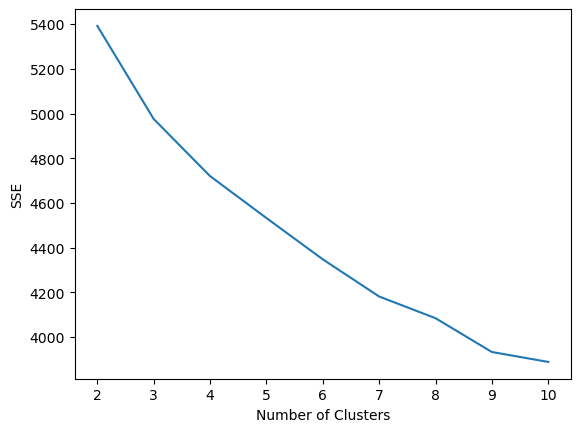

In [35]:
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

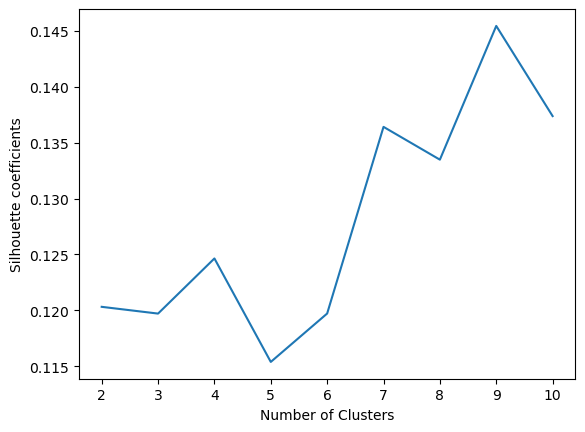

In [36]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")
plt.show()

In [48]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
anime_clusters = kmeans.fit_predict(clustering_features)
anime_clusters_visual = kmeans.fit(clustering_features)

In [49]:
anime_with_clusters = anime_df.copy()

anime_with_clusters['Cluster'] = anime_clusters_visual.labels_
anime_with_clusters.head()

,anime_uid,name,synopsis,genre,episodes,members,popularity,rating,Cluster
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,1
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen",22.0,995473,28,8.83,3
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",13.0,581663,98,8.83,2
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire",1.0,214621,502,8.83,0


In [50]:
cluster0 = anime_with_clusters[anime_with_clusters['Cluster']==0].drop('Cluster',axis=1).mean()

C:\Users\Haaris PC\AppData\Local\Temp\ipykernel_26152\2603613714.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cluster0 = anime_with_clusters[anime_with_clusters['Cluster']==0].drop('Cluster',axis=1).mean()


In [51]:
cluster0.sort_values(ascending=False)[0:15]

members       40859.277995
anime_uid     12927.652702
popularity     6065.253720
episodes         12.191856
rating            6.618990
dtype: float64

In [52]:
anime_with_clusters.Cluster.value_counts()

3    5746
1    4093
2    2557
0    2554
Name: Cluster, dtype: int64

Visualising clusters

In [53]:
def cluster_plot(data, nclusters):
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    X = data.copy()

    km = KMeans(n_clusters=nclusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)
    
    # Visualize it:
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=km.labels_.astype(float))

    # plot the centroids
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', label='centroids')
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

In [69]:
test = anime_with_clusters.copy()
anime_with_clusters.head()

,anime_uid,name,synopsis,genre,episodes,members,popularity,rating,Cluster
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,1
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen",22.0,995473,28,8.83,3
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",13.0,581663,98,8.83,2
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,2
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire",1.0,214621,502,8.83,0


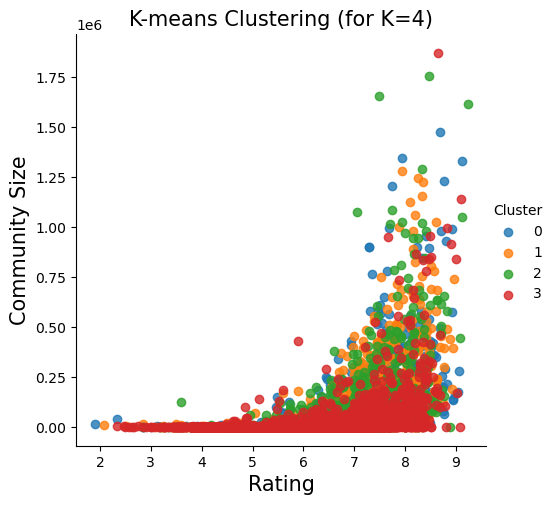

In [68]:
import seaborn as sns

sns.lmplot(x = 'rating', y = 'members', data = anime_with_clusters, hue = 'Cluster', fit_reg = False)

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('K-means Clustering (for K=4)', fontsize = 15)
plt.ylabel('Community Size', fontsize = 15)
plt.xlabel('Rating', fontsize = 15)

# display the plot
plt.show()

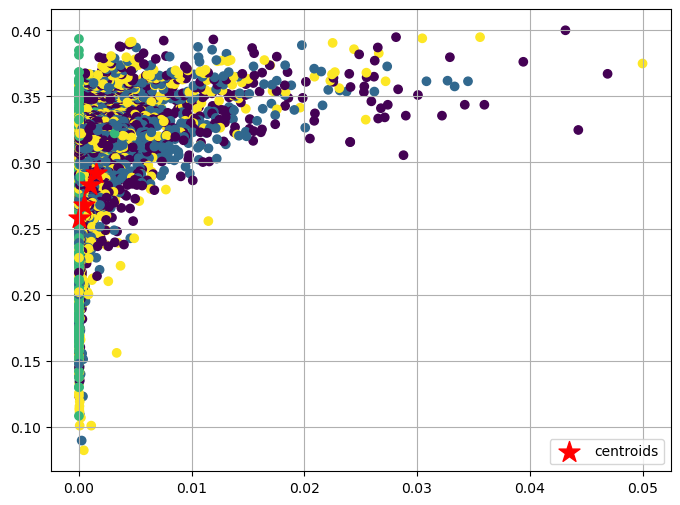

In [54]:
clusters = clustering_features
cluster_plot(clusters, 4)

Provide content based recommendations

In [55]:
# return a list of similar anime that belong to the same cluster as the input anime
def get_similar_anime(anime_name, n_recommendations=20):
    anime_index = anime_df[anime_df['name'] == anime_name].index[0]
    anime_cluster = anime_clusters[anime_index]
    similar_anime_indexes = [i for i, cluster in enumerate(anime_clusters) if cluster == anime_cluster and i != anime_index]
    similar_anime = anime_df.iloc[similar_anime_indexes]['name'].tolist()
    
    return similar_anime[:n_recommendations+1]

In [63]:
get_similar_anime('Naruto')

['Haikyuu Second Season',
 'Mob Psycho 100 II',
 'Owarimonogatari 2nd Season',
 'Haikyuu Karasuno Koukou vs Shiratorizawa Gakuen Koukou',
 'Clannad After Story',
 'Nodame Cantabile Finale  Mine to Kiyora no Saikai',
 'Noragami OVA',
 'Lupin III Part II',
 'Kobayashisan Chi no Maid Dragon Valentine Soshite Onsen  Amari Kitai Shinaide Kudasai',
 'Kuroko no Basket 2nd Season NGshuu',
 'KOn Live House',
 'KOn',
 'Haikyuu Movie 2 Shousha to Haisha',
 'Gekkan Shoujo Nozakikun Specials',
 'Doukyonin wa Hiza Tokidoki Atama no Ue',
 'Detective Conan OVA 10 Kid in Trap Island',
 'Bungou Stray Dogs Dead Apple',
 'Ansatsu Kyoushitsu 2nd Season Kagaijugyouhen',
 'Toshokan Sensou Kakumei no Tsubasa',
 'Paradise Kiss',
 'Manga de Wakaru FateGrand Order']

In [ ]:
['Haikyuu Second Season',
 'Mob Psycho 100 II',
 'Owarimonogatari 2nd Season',
 'Haikyuu Karasuno Koukou vs Shiratorizawa Gakuen Koukou',
 'Clannad After Story',
 'Nodame Cantabile Finale  Mine to Kiyora no Saikai',
 'Noragami OVA',
 'Lupin III Part II',
 'Kobayashisan Chi no Maid Dragon Valentine Soshite Onsen  Amari Kitai Shinaide Kudasai',
 'Kuroko no Basket 2nd Season NGshuu',
 'KOn Live House',
 'KOn',
 'Haikyuu Movie 2 Shousha to Haisha',
 'Gekkan Shoujo Nozakikun Specials',
 'Doukyonin wa Hiza Tokidoki Atama no Ue',
 'Detective Conan OVA 10 Kid in Trap Island',
 'Bungou Stray Dogs Dead Apple',
 'Ansatsu Kyoushitsu 2nd Season Kagaijugyouhen',
 'Toshokan Sensou Kakumei no Tsubasa',
 'Paradise Kiss',
 'Manga de Wakaru FateGrand Order']

Measuring performance using different metrics

MAE (Mean Absolute Error)